In [1]:
# -*- coding: utf-8 -*-
import recon
import plotting as plot
import numpy as np
import seaborn as sns
import pandas as pd
import utilities
import workflows as wf
import warnings
warnings.filterwarnings('ignore')


model = recon.Recon()
util = utilities.Utilities()
sns.set_context("talk")

### Metabolomics data

In [2]:
met_slc25a51ko = pd.read_csv('../data/metabolomics_slc25a51ko_vs_parental.csv', 
                             sep='\t', index_col=0)
met_uc = pd.read_csv('../data/metabolomics_uc_vs_healthy.csv', sep=',')

### RNA-Seq data

In [3]:
rna_slc25a51ko = pd.read_csv('../data/rnaseq_slc25a51ko_vs_parental.csv', sep='\t', index_col=0)
rna_slc25a51ko = util.map_gene(df=rna_slc25a51ko, g_mapping=model.genes, mapping_column='ensembl_gene')

### Proteomics data (UC vs Healthy)

In [5]:
prot_uc = pd.read_csv('../data/prot_uc_vs_healthy.csv', sep='\t', index_col=0)
recon_genes = pd.read_csv('./recon-store-genes.tsv', sep='\t')
prot_uc = util.map_gene(prot_uc, g_mapping=recon_genes, mapping_column='symbol')

### Predicted change

In [62]:
res_slc25a51ko = pd.read_csv('../data/pr_slc25a51ko_wt.csv', sep='\t', index_col=0)

res_uc = pd.read_csv('../data/pr_prot_uc_vs_healthy.csv', sep='\t', index_col=0)

# Histograms

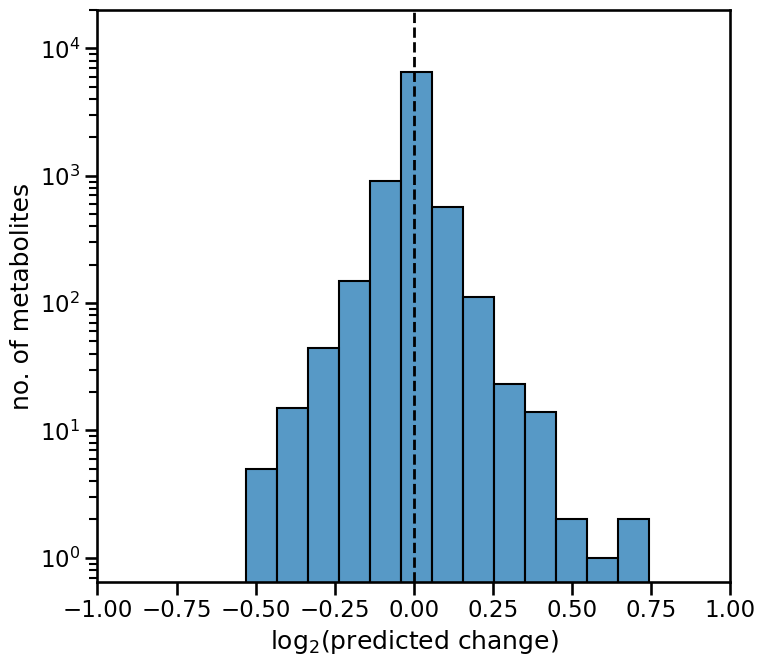

In [16]:
# Figure 2a
plot.hist(pr=np.log2(res_slc25a51ko.mean(axis=1)), bins=13, figsize=(8, 7), xlim=(-1.0, 1.0),
          ylim=(0, 2e4), xlabel='log$_2$(predicted change)', ylabel='no. of metabolites',
          save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_2a.svg')

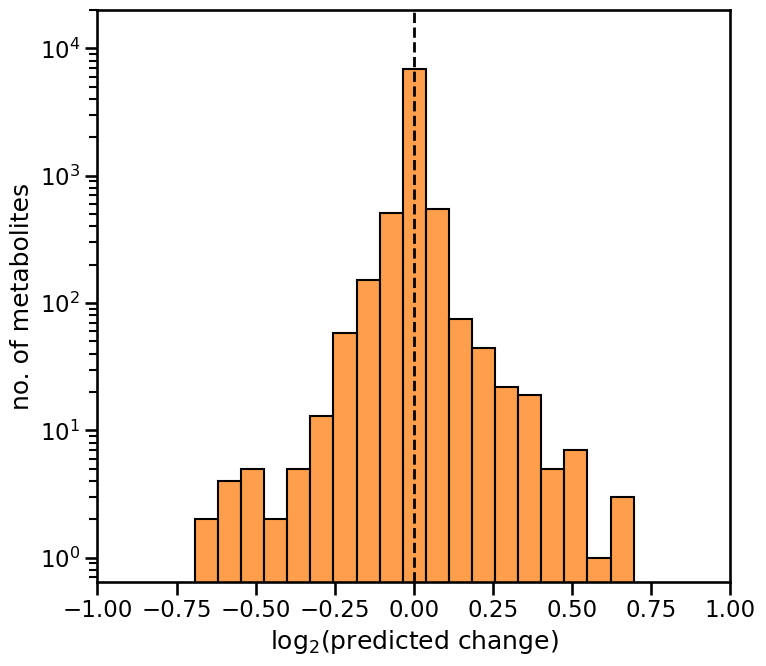

In [63]:
# Figure 3a
plot.hist(pr=np.log2(res_uc.mean(axis=1)),
          figsize=(8,7), xlim=(-1., 1.), bins=19, color='C1', ylim=(0, 2e4),
          xlabel='log$_2$(predicted change)', ylabel='no. of metabolites',
          save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_3a.svg')

In [64]:
75.86+3.45

79.31

# Parity plots

In [18]:
res_HEK = util.reshape(res_slc25a51ko, include=None)
# _res = res_HEK.groupby('metabolites').mean(numeric_only=True)
_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
df = wf.prep_data(model=model, rna=rna_slc25a51ko, mets=met_slc25a51ko, res=_res)

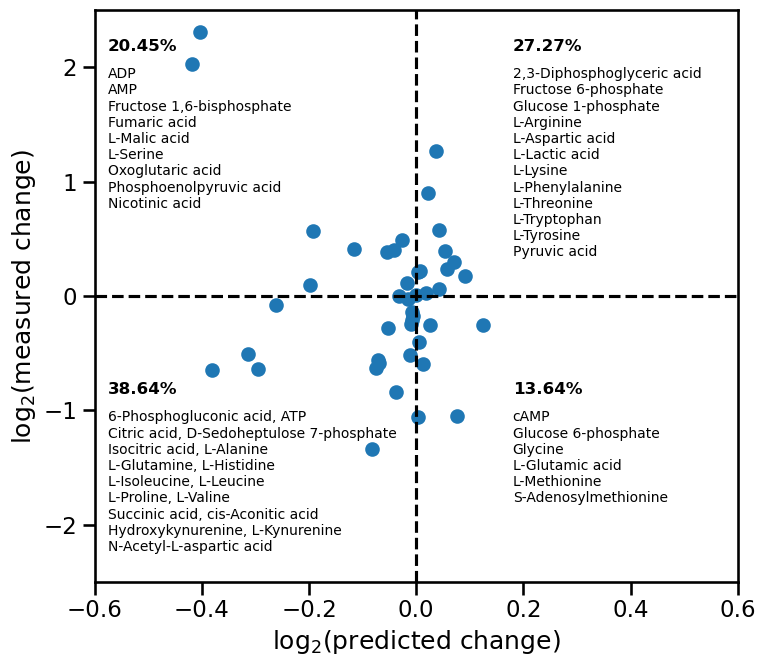

In [21]:
# Figure 2b
_df = df[~df.index.isin(['D-Glucose', ])]
plot.parity(data=_df, xcolumn='Measured', ycolumn='Predicted',
            show_percentage=True, show_names=True, alpha=1.0, 
            figsize=(8, 7), edgecolor=None,
            ylabel='log$_2$(measured change)', xlabel='log$_2$(predicted change)',
            n=[1, 1, 2, 1], fsize=10, xlim=(-0.6, 0.6), ylim=(-2.5, 2.5),
            l_p=[(0.02, 0.95), (0.65, 0.95), (0.02, 0.35), (0.65, 0.35)],
            l_n=[(0.02, 0.90), (0.65, 0.90), (0.02, 0.30), (0.65, 0.30)],
            save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_2b.svg')

In [22]:
# Figure 3b
df = util.reshape(res_uc).groupby('metabolites').mean(numeric_only=True).reset_index()
df = met_uc.merge(df, right_on='metabolites', left_on='vmh', how='inner')
df = df.set_index('metabolites').drop('vmh', axis=1)
df.columns = ['p', 'padj', 'Measured', 'Predicted']
df['hue'] = 'C1'
df.loc[(df.p > 0.05), 'hue'] = 'grey'
df.loc[(df.Predicted < 1.01) & (df.Predicted > 0.99), 'hue'] = 'grey'
df.loc[(df.Measured < 1.2) & (df.Measured > 0.8), 'hue'] = 'grey'

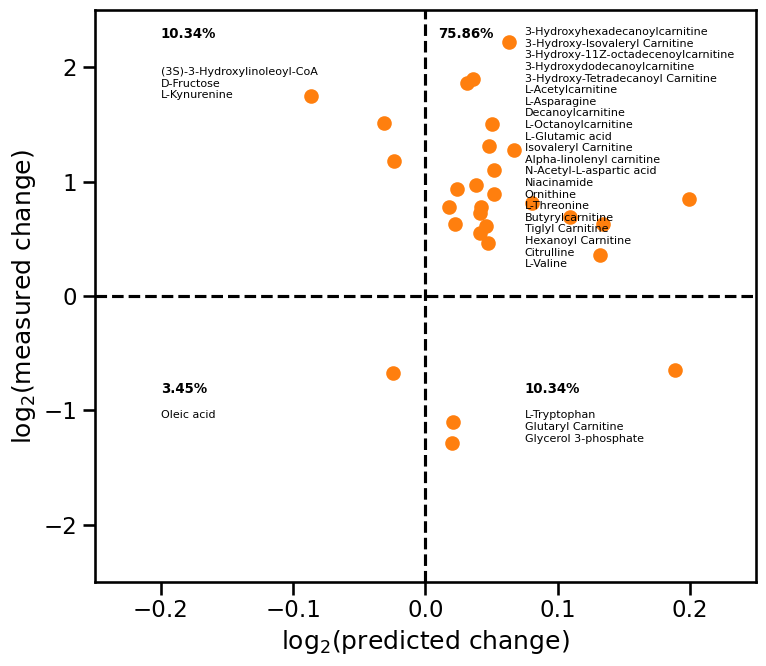

In [66]:
plot.parity(data=df.loc[df.hue == 'C1'], xcolumn='Measured', ycolumn='Predicted',
            show_percentage=True, show_names=True, alpha=1.0,
            xlim=(-0.25, 0.25), ylim=(-2.5, 2.5), edgecolor=None,
            ylabel='log$_2$(measured change)', xlabel='log$_2$(predicted change)',
            n=[1, 1, 2, 1], figsize=(8, 7), color='C1',
            l_p=[(0.1, 0.97), (0.52, 0.97), (0.1, 0.35), (0.65, 0.35)],
            l_n=[(0.1, 0.90), (0.65, 0.97), (0.1, 0.30), (0.65, 0.30)],
            fsize=8, save=True, filename='../../biomarker_predictions/manuscript/submission/images/Figure_3b.svg')

## Figure 4

In [108]:
rna = pd.read_csv('../../biomarker_predictions/data/NAD_cell_lines/gene_fpkm.xls.csv', index_col=0)
rna = rna[rna.columns[rna.columns.str.contains('wtHEK293|HEK25a51|HEK25A51')]]
rna = rna[~(rna == 0).any(axis=1)]
rna = util.map_gene(df=rna, g_mapping=model.genes,
                    mapping_column='ensembl_gene')

rna = pd.concat((rna.filter(like='wtHEK').mean(
    axis=1), rna.filter(like='HEK25a51ko').mean(axis=1)), axis=1)
rna.columns = ['wt', 'ko']
rdict = (rna['ko']-(rna['wt'])).div(rna['wt'], axis=0)
rdict = rdict.replace(np.inf, np.nan).dropna()

In [109]:
gs = model.gs

gnames = model.genes.set_index('gene_number').to_dict()['symbol']
gnames = {str(k): v for k,v in gnames.items()}

met_slc25a51ko = pd.read_csv('../data/metabolomics_slc25a51ko_vs_parental.csv',
                             sep='\t')
_gs = util.reshape(gs.T.mul(rdict, axis=0).dropna().T, include=None)
gs_met = _gs[_gs.metabolites.isin(met_slc25a51ko.fullName.unique())]
gs_met = gs_met[gs_met.compartment != 'extracellular'].groupby('metabolites').mean(numeric_only=True)

gs_met = gs_met.rename(columns=gnames)

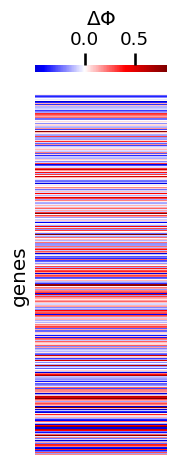

In [110]:
# Figure 4b
sns.set_context('talk', font_scale=0.8)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2., 5))
cm = sns.heatmap(data=pd.DataFrame(rdict), cmap='seismic',
                 center=0, robust=True, xticklabels=False, yticklabels=False,
                 ax=ax, cbar_kws={'label': '$\Delta\Phi$', 'location': 'top'},
                 )
cm.set_ylabel('genes');
plt.tight_layout()

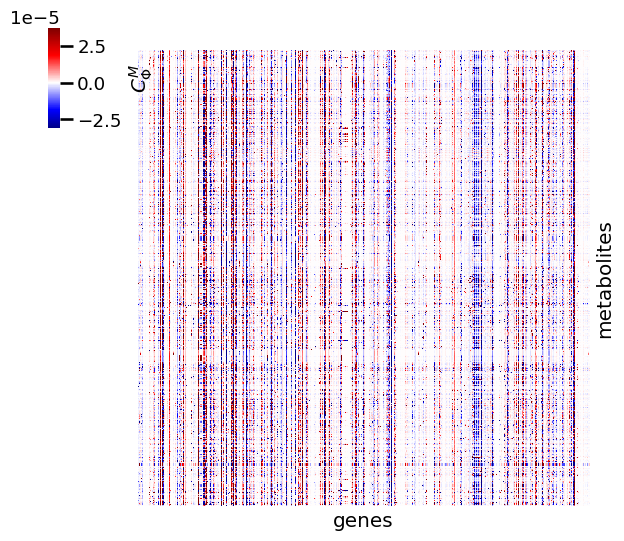

In [111]:
# Fugure 4b
cm = sns.clustermap(data=_gs.groupby('metabolites').mean(numeric_only=True), cmap='seismic', center=0, robust=True,
                    figsize=(6, 5), yticklabels=False, dendrogram_ratio=(0.15, 0.0), method='ward',
                    xticklabels=False, cbar_kws={'label': '$C_{\Phi}^{M}$'}, cbar_pos=(0.02, 0.8, 0.02, 0.2),
                    col_cluster=False, row_cluster=False,
                    )
cm.ax_heatmap.set_xlabel('genes');
cm.ax_heatmap.set_ylabel('metabolites');

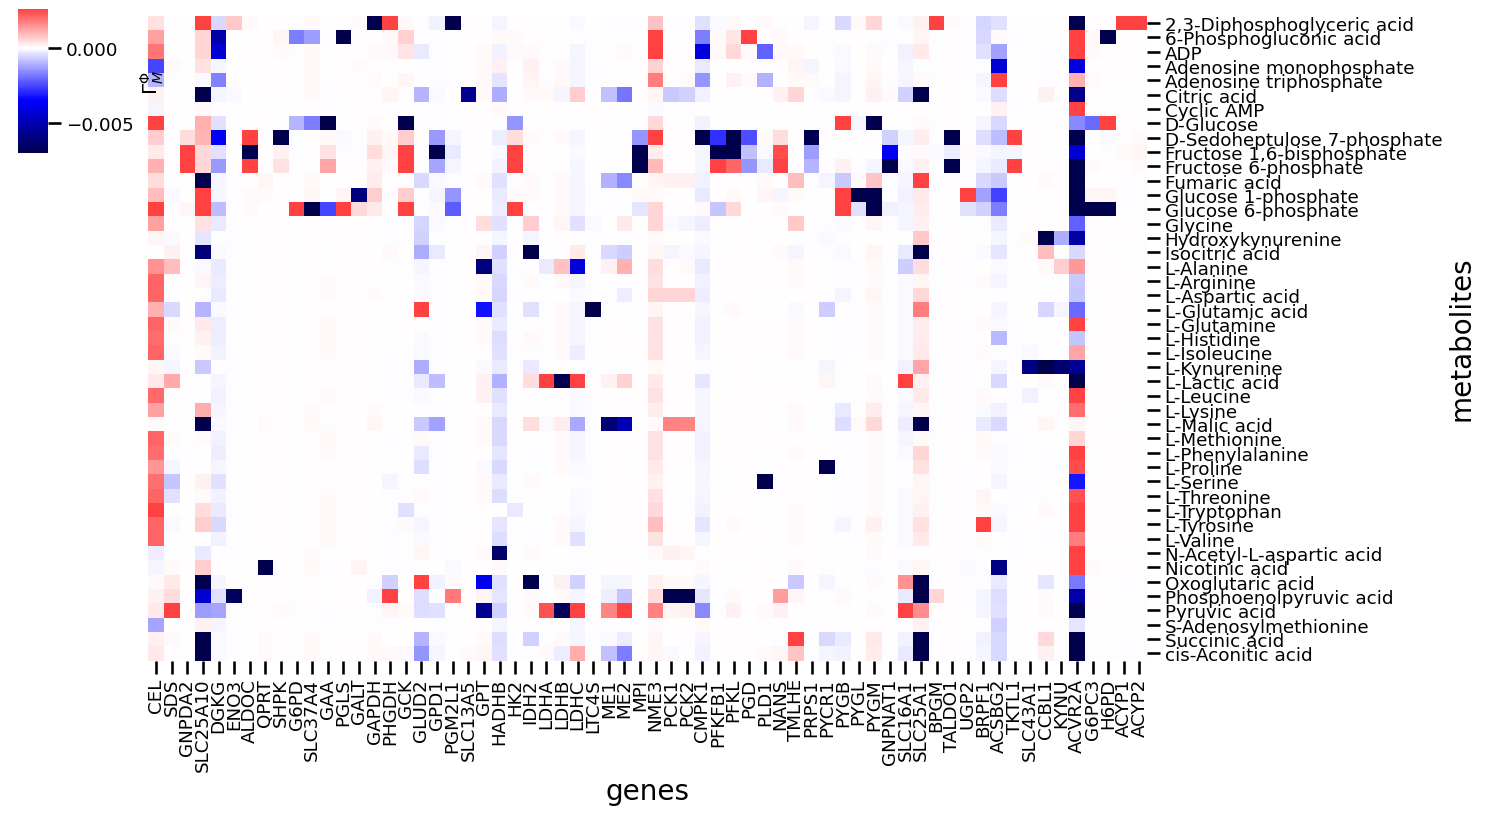

In [112]:
# Figure 4d
sns.set_context('talk', font_scale=0.8)

df = pd.read_csv('../data/Supplementary_Table_S1.csv', sep='\t', index_col=0)
consistent = util.get_consistent_mets(df[['Measured', 'Predicted']]).index.to_list()

_gs_met = gs_met.T[(gs_met.T.abs() > 0.005).any(axis=1)].T

cm = sns.clustermap(data=_gs_met, cmap='seismic', center=0, robust=True,
                    col_cluster=False, row_cluster=False,
                    figsize=(15, 8), yticklabels=True, dendrogram_ratio=(0.12, 0.0), method='weighted',
                    xticklabels=True, cbar_kws={'label': '$\Gamma^{\Phi}_{M}$'}, cbar_pos=(0.02, 0.8, 0.02, 0.18),
                    )
cm.ax_heatmap.set_xlabel('genes', fontdict={'size': 20});
cm.ax_heatmap.set_ylabel('metabolites', fontdict={'size': 20});